In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
def calculate_technical_indicators(df):
    df = df.copy()
    df['SMA_20'] = df['Adj Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Adj Close'].rolling(window=50).mean()
    delta = df['Adj Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df['EMA_20'] = df['Adj Close'].ewm(span=20, adjust=False).mean()
    return df

In [3]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
stocks_data = {}
for ticker in tickers:
    print(f"Baixando dados para {ticker}...")
    data = yf.download(ticker, start="2017-01-01", end="2023-12-31")
    if 'Adj Close' in data.columns:
        data = calculate_technical_indicators(data)
        data.dropna(inplace=True)  
        stocks_data[ticker] = data
    else:
        print(f"Coluna 'Adj Close' não encontrada para {ticker}")

Baixando dados para AAPL...


[*********************100%***********************]  1 of 1 completed


Baixando dados para MSFT...


[*********************100%***********************]  1 of 1 completed


Baixando dados para GOOGL...


[*********************100%***********************]  1 of 1 completed


Baixando dados para AMZN...


[*********************100%***********************]  1 of 1 completed


Baixando dados para META...


[*********************100%***********************]  1 of 1 completed


In [4]:
file_path = '/Users/pedrobueno/Desktop/Modelos ML/World Bank/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_3403845.csv'
df_pib = pd.read_csv(file_path, sep=';', skiprows=4)
df_pib_filtered = df_pib.loc[:, '2017':'2023']
df_pib_filtered = df_pib_filtered.T.reset_index()
df_pib_filtered.columns = ['Year', 'GDP']
df_pib_filtered['Date'] = pd.to_datetime(df_pib_filtered['Year'] + '-01-01')
df_pib_daily = pd.DataFrame(index=pd.date_range(start="2017-01-01", end="2024-01-01"))
df_pib_daily['GDP'] = np.nan

In [5]:
for i, row in df_pib_filtered.iterrows():
    start_date = row['Date']
    if i < len(df_pib_filtered) - 1:
        end_date = df_pib_filtered.loc[i + 1, 'Date'] - pd.DateOffset(days=1)
    else:
        end_date = pd.to_datetime('2024-01-01')
    df_pib_daily.loc[start_date:end_date, 'GDP'] = row['GDP']

In [7]:
X_all = pd.DataFrame()
y_all = pd.Series(dtype='float64')
for ticker in tickers:
    X = stocks_data[ticker].copy()
    train_size = int(len(X) * 0.8)  
    X_train = X.iloc[:train_size]
    X_test = X.iloc[train_size:]
    # Adicionando PIB
    X_train = X_train.join(df_pib_daily['GDP'], how='left')
    X_test = X_test.join(df_pib_daily['GDP'], how='left')
    # Criando y com base em Adj Close (deslocado para prever o próximo dia)
    y_train = X_train['Adj Close'].shift(-1).dropna()
    y_test = X_test['Adj Close'].shift(-1).dropna()
    X_train.dropna(inplace=True)
    X_test.dropna(inplace=True)
    
    if len(y_train) != len(X_train):
        min_len = min(len(y_train), len(X_train))
        X_train = X_train.iloc[:min_len]
        y_train = y_train.iloc[:min_len]
        

In [8]:
    X_all = pd.concat([X_all, X_train])
    y_all = pd.concat([y_all, y_train], ignore_index=True)

In [9]:
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'GDP', 'SMA_20', 'SMA_50', 'RSI', 'EMA_20']
X_all = X_all[features]

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)
model = LinearRegression()
model.fit(X_scaled, y_all)

LinearRegression()

In [11]:
y_pred = model.predict(X_scaled)

In [12]:
df_results = pd.DataFrame({'Real': y_all, 'Predito': y_pred})
mse = mean_squared_error(df_results['Real'], df_results['Predito'])
mae = mean_absolute_error(df_results['Real'], df_results['Predito'])
r2 = r2_score(df_results['Real'], df_results['Predito'])

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")

Mean Squared Error: 29.001262181606997
Mean Absolute Error: 3.4062707666507968
R2 Score: 0.992751170761697


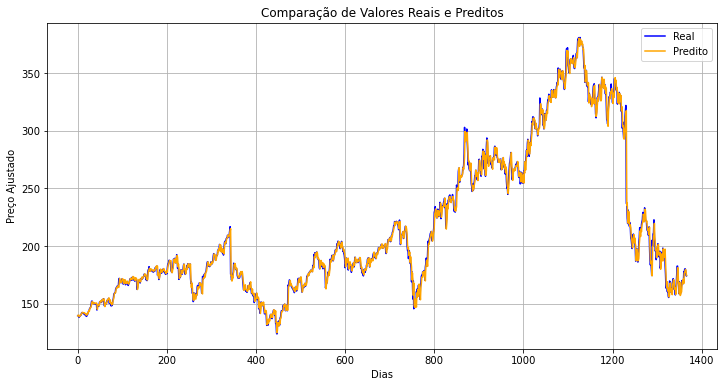

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(df_results['Real'].values, label='Real', color='blue')
plt.plot(df_results['Predito'].values, label='Predito', color='orange')
plt.title('Comparação de Valores Reais e Preditos')
plt.xlabel('Dias')
plt.ylabel('Preço Ajustado')
plt.legend()
plt.grid()
plt.show()